# Air Quality Analysis in Lagos, Nigeria (Nov 2023 – Apr 2025)

This notebook explores air quality trends in Lagos using PM₂.₅ data from Sensor.Africa.  
I clean, combine, and analyze readings from multiple monthly datasets, focusing on daily, weekly, and monthly PM₂.₅ patterns.

**Objectives**
- Understand how PM₂.₅ levels change over time.
- Detect pollution spikes and seasonal trends.
- Assess air quality compliance with WHO standards.

**Data Source:** Sensor.Africa Open Air Quality Data (Lagos Stations)


In [63]:
# imports
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
import itertools

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', FutureWarning)


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [64]:
# Path to dataset folder
data_path = "/kaggle/input/sensors-africa-air-quality-archive-lagos/"

# List all CSV files in folder
csv_files = glob.glob(os.path.join(data_path, "*.csv"))

print("Number of files:", len(csv_files))
print("Found files:", list(csv_files))

Number of files: 18
Found files: ['/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_apr2024.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_dec2024.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_dec2023.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_feb2024.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_jul2024.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_jan2025.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_mar2025.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_aug2024.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_jun2024.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_may2024.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_apr2025.csv', '/kaggle/input/sensors-africa-air-quality-archive-lagos/lagos_air_jan2024.csv', '/kagg

## Data Loading and Preparation

I start by loading multiple monthly CSV files, combining them into a single DataFrame,  
and filtering only for PM₂.₅ (`value_type == 'P2'`).

I also convert timestamps to Lagos local time (WAT) for accurate daily and weekly analysis.


In [65]:
# Read and combine
df_list = []
for file in csv_files:
    temp = pd.read_csv(file)
    df_list.append(temp)

# Concatenate into one DataFrame
df = pd.concat(df_list, ignore_index=True)

In [66]:
# Check shape and preview
print("Combined shape:", df.shape)
df.head()

Combined shape: (340710, 1)


,sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value
0,4851;pms5003;3627;6.515;3.400;2024-04-02T05:39...
1,4851;pms5003;3627;6.515;3.400;2024-04-02T05:39...
2,4851;pms5003;3627;6.515;3.400;2024-04-02T05:39...
3,4852;DHT22;3627;6.515;3.400;2024-04-02T05:39:3...
4,4852;DHT22;3627;6.515;3.400;2024-04-02T05:39:3...


In [67]:
# Re read csv files specifying pandas to use semicolon as delimiter
df_list = []
for file in csv_files:
    temp = pd.read_csv(file, sep=";")  # specify delimiter
    df_list.append(temp)

# Concatenate into one DataFrame
df = pd.concat(df_list, ignore_index=True)

print("Combined shape:", df.shape)
print(df.head(15))


Combined shape: (340710, 8)
    sensor_id sensor_type  location    lat  lon  \
0        4851     pms5003      3627  6.515  3.4   
1        4851     pms5003      3627  6.515  3.4   
2        4851     pms5003      3627  6.515  3.4   
3        4852       DHT22      3627  6.515  3.4   
4        4852       DHT22      3627  6.515  3.4   
5        4851     pms5003      3627  6.515  3.4   
6        4851     pms5003      3627  6.515  3.4   
7        4851     pms5003      3627  6.515  3.4   
8        4852       DHT22      3627  6.515  3.4   
9        4852       DHT22      3627  6.515  3.4   
10       4851     pms5003      3627  6.515  3.4   
11       4851     pms5003      3627  6.515  3.4   
12       4851     pms5003      3627  6.515  3.4   
13       4852       DHT22      3627  6.515  3.4   
14       4852       DHT22      3627  6.515  3.4   

                           timestamp   value_type  value  
0   2024-04-02T05:39:23.644999+00:00           P2  21.22  
1   2024-04-02T05:39:23.644999+00:00 

In [68]:
# Keep only PM2.5 readings (P2)
df_pm25 = df[df["value_type"] == "P2"].copy()


In [69]:
# Preview
print(df_pm25.shape)
df_pm25.head()

(73601, 8)


,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,4851,pms5003,3627,6.515,3.4,2024-04-02T05:39:23.644999+00:00,P2,21.22
5,4851,pms5003,3627,6.515,3.4,2024-04-02T05:40:38.131739+00:00,P2,22.33
10,4851,pms5003,3627,6.515,3.4,2024-04-02T05:41:48.753599+00:00,P2,19.33
15,4851,pms5003,3627,6.515,3.4,2024-04-02T05:42:57.035064+00:00,P2,22.00
20,4851,pms5003,3627,6.515,3.4,2024-04-02T05:44:00.941964+00:00,P2,20.00


In [70]:
# check for NaNs
print(df_pm25.isna().sum())   

# quick summary
print(df_pm25["value"].describe())  


sensor_id      0
sensor_type    0
location       0
lat            0
lon            0
timestamp      0
value_type     0
value          0
dtype: int64
count    73601.000000
mean        34.024268
std         26.748584
min          0.000000
25%         19.000000
50%         29.000000
75%         40.000000
max        690.000000
Name: value, dtype: float64


In [71]:
# Ensure timestamp is datetime
df_pm25["timestamp"] = pd.to_datetime(df_pm25["timestamp"], errors="coerce")

# Set as index
df_pm25 = df_pm25.set_index('timestamp').sort_index()

# convert to Lagos time
df_pm25 = df_pm25.tz_convert("Africa/Lagos")

# Check missing values
print(df_pm25.isna().sum())

# Verify
print(df_pm25.index[:5])


sensor_id      0
sensor_type    0
location       0
lat            0
lon            0
value_type     0
value          0
dtype: int64
DatetimeIndex(['2023-11-01 17:44:52.764459+01:00',
               '2023-11-01 18:52:08.924982+01:00',
               '2023-11-01 18:53:13.805911+01:00',
               '2023-11-01 19:16:42.515782+01:00',
               '2023-11-03 08:38:39.664224+01:00'],
              dtype='datetime64[ns, Africa/Lagos]', name='timestamp', freq=None)


## Exploratory Data Analysis
I begin by understanding the raw PM₂.₅ distribution to identify outliers and assess the general air quality level.


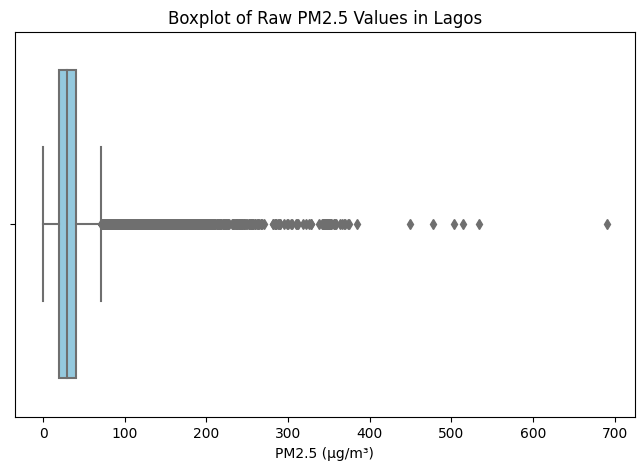

In [72]:
# create boxplot of PM2.5 to see distribution
plt.figure(figsize=(8,5))
sns.boxplot(x=df_pm25["value"], color="skyblue")
plt.title("Boxplot of Raw PM2.5 Values in Lagos")
plt.xlabel("PM2.5 (µg/m³)")
plt.show()

The boxplot shows several extreme outliers, likely sensor errors or one-off events.  
I removed PM₂.₅ readings above **500 µg/m³** to ensure cleaner analysis.


In [73]:
# Remove extreme outliers (> 500)
df_pm25_clean = df_pm25[df_pm25["value"] <= 500].copy()

print("Before cleaning:", df_pm25.shape[0], "rows")
print("After cleaning:", df_pm25_clean.shape[0], "rows")


Before cleaning: 73601 rows
After cleaning: 73597 rows


### Handling Missing Data with Time Interpolation

The raw PM2.5 readings contained missing timestamps after daily resampling.  
To handle these gaps, I used **time-based interpolation** (`interpolate(method='time')`).

This method estimates missing values based on the trend of surrounding data points, ensuring smooth continuity in the time series.  
I chose interpolation instead of forward filling because air quality values (PM2.5) tend to change gradually rather than abruptly,  
and interpolation better preserves those natural fluctuations for accurate trend analysis and forecasting.


In [74]:

# Resample daily mean from cleaned dataset
df_daily = df_pm25_clean['value'].resample('D').mean()

# Interpolate small missing gaps (time-based)
df_daily = df_daily.interpolate(method='time')

# Ensure float dtype and daily frequency
df_daily = df_daily.astype(float).asfreq('D')

# Quick info and preview
print(df_daily.info())
display(df_daily.head(10))

<class 'pandas.core.series.Series'>
DatetimeIndex: 518 entries, 2023-11-01 00:00:00+01:00 to 2025-04-01 00:00:00+01:00
Freq: D
Series name: value
Non-Null Count  Dtype  
--------------  -----  
518 non-null    float64
dtypes: float64(1)
memory usage: 8.1 KB
None


timestamp
2023-11-01 00:00:00+01:00    16.457500
2023-11-02 00:00:00+01:00    26.262759
2023-11-03 00:00:00+01:00    36.068019
2023-11-04 00:00:00+01:00    36.599627
2023-11-05 00:00:00+01:00    37.131235
2023-11-06 00:00:00+01:00    37.662843
2023-11-07 00:00:00+01:00    38.194451
2023-11-08 00:00:00+01:00    38.726059
2023-11-09 00:00:00+01:00    39.257667
2023-11-10 00:00:00+01:00    39.789275
Freq: D, Name: value, dtype: float64

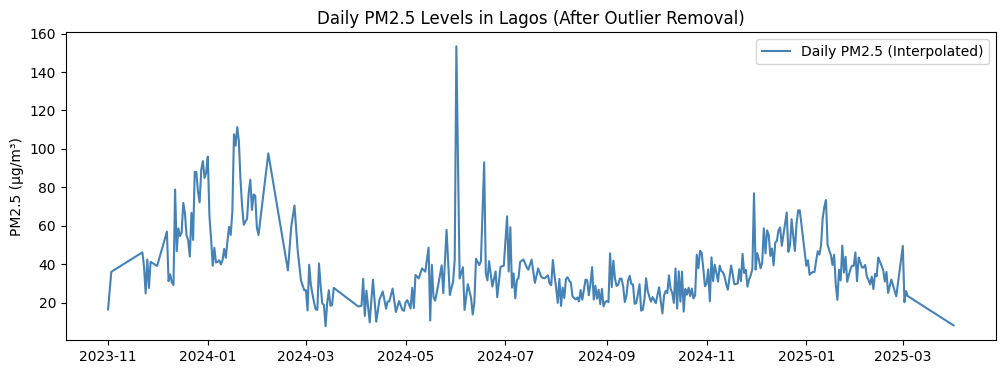

In [75]:
# Plot to visualize the clean daily series
plt.figure(figsize=(12,4))
plt.plot(df_daily.index, df_daily.values, color='steelblue', label='Daily PM2.5 (Interpolated)')
plt.title("Daily PM2.5 Levels in Lagos (After Outlier Removal)")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()

### Time-Series Behavior of PM₂.₅ in Lagos
To capture temporal patterns, I visualize daily, weekly, and monthly averages of PM₂.₅ levels. This helps identify recurring pollution patterns and long-term trends.

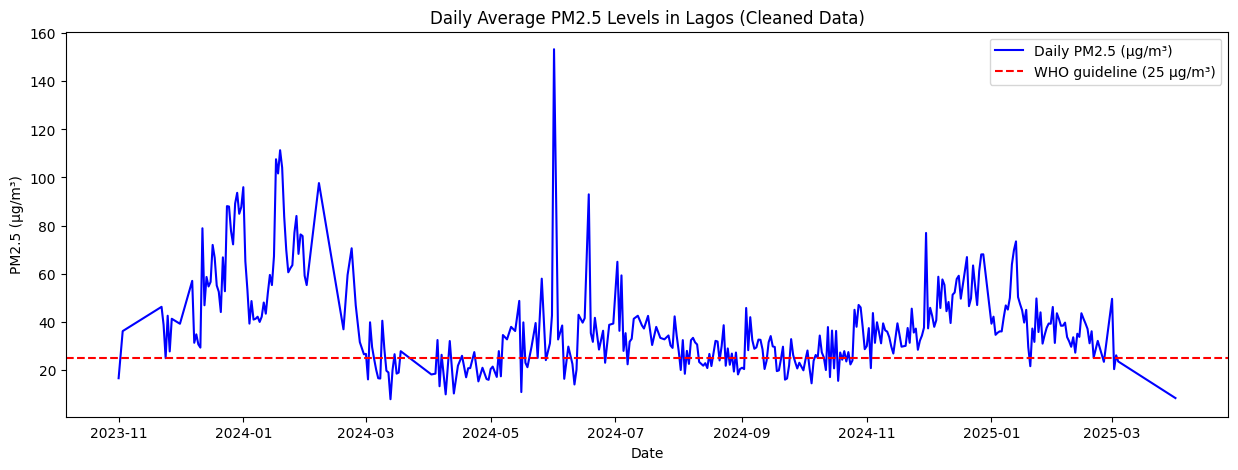

In [76]:
# Daily time series plot
plt.figure(figsize=(15,5))
plt.plot(df_daily.index, df_daily.values, label="Daily PM2.5 (µg/m³)", color="blue")
plt.axhline(25, color="red", linestyle="--", label="WHO guideline (25 µg/m³)")
plt.title("Daily Average PM2.5 Levels in Lagos (Cleaned Data)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()


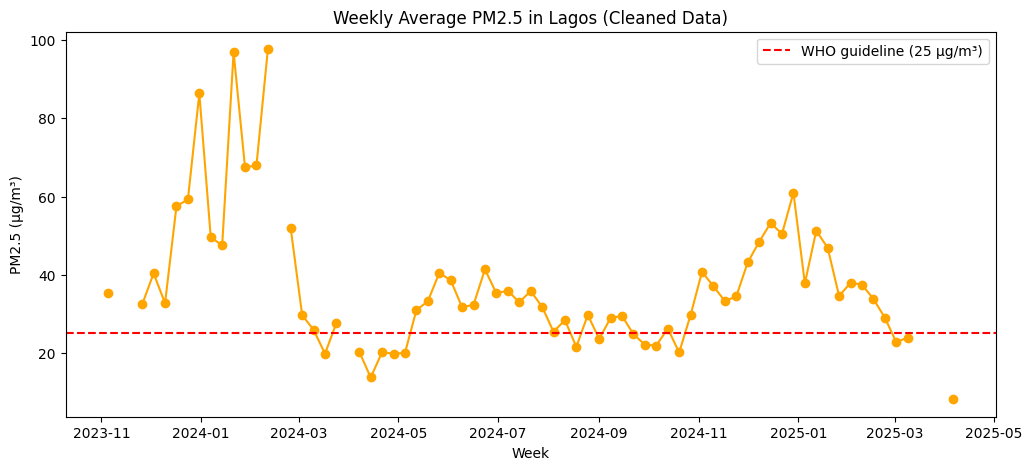

In [77]:
# Weekly resample
df_weekly = df_pm25_clean["value"].resample("W").mean()

# Weekly time series plot
plt.figure(figsize=(12,5))
plt.plot(df_weekly.index, df_weekly.values, marker="o", color="orange")
plt.axhline(25, color="red", linestyle="--", label="WHO guideline (25 µg/m³)")
plt.title("Weekly Average PM2.5 in Lagos (Cleaned Data)")
plt.xlabel("Week")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()


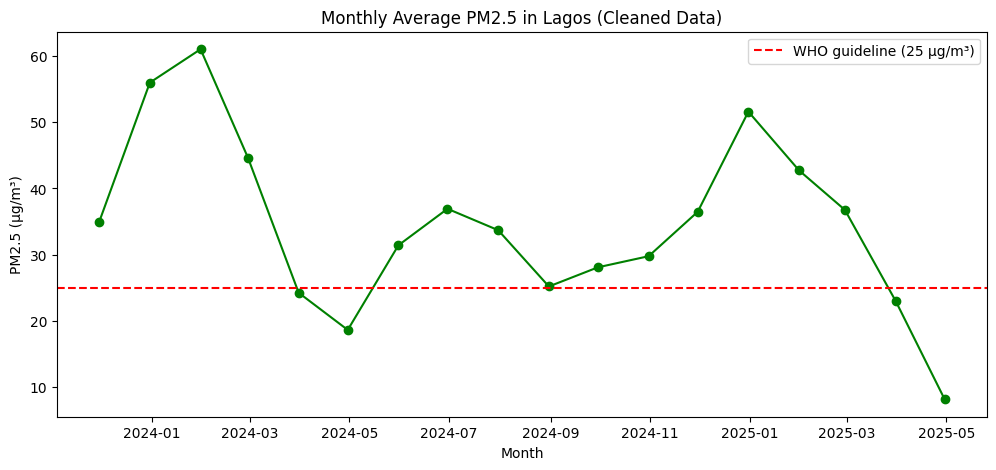

In [78]:
# Monthly resample
df_monthly = df_pm25_clean["value"].resample("ME").mean()

# Monthly time series plot
plt.figure(figsize=(12,5))
plt.plot(df_monthly.index, df_monthly.values, marker="o", color="green")
plt.axhline(25, color="red", linestyle="--", label="WHO guideline (25 µg/m³)")
plt.title("Monthly Average PM2.5 in Lagos (Cleaned Data)")
plt.xlabel("Month")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()


### 30-Day Rolling Average

To smooth short-term fluctuations and highlight long-term pollution trends,  
I applied a 30-day rolling average to the daily PM₂.₅ data.

The red line below shows the smoothed trend, which makes seasonal variations and  
persistent high-pollution periods easier to identify.


In [79]:
# Calculate 30-day rolling mean
daily_rolling = df_daily.rolling(window=30, min_periods=1).mean()


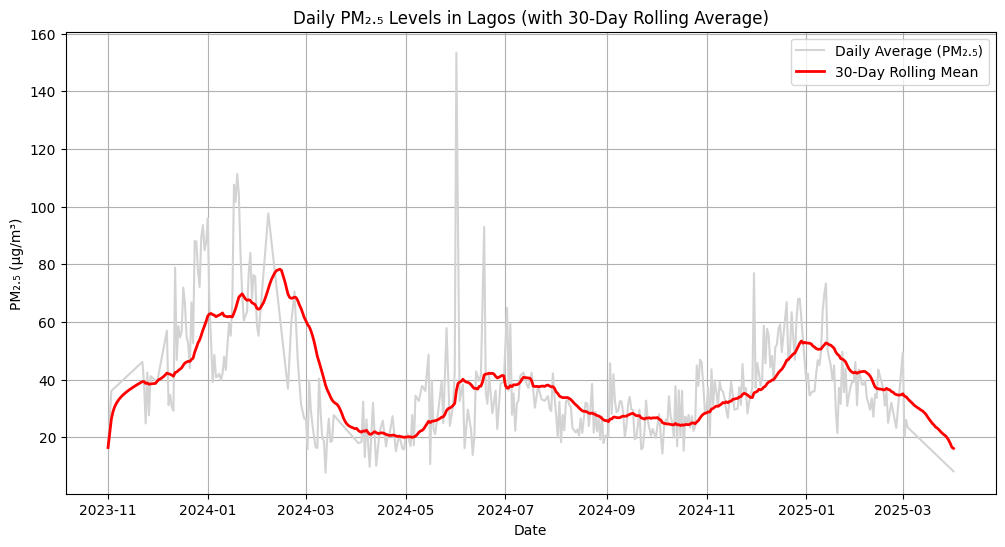

In [80]:
# Plot Both the Daily Data and Rolling Average
plt.figure(figsize=(12,6))
plt.plot(df_daily.index, df_daily, color='lightgray', label='Daily Average (PM₂.₅)')
plt.plot(daily_rolling.index, daily_rolling, color='red', linewidth=2, label='30-Day Rolling Mean')

plt.title('Daily PM₂.₅ Levels in Lagos (with 30-Day Rolling Average)')
plt.xlabel('Date')
plt.ylabel('PM₂.₅ (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()


### Observations on the Rolling Average

Despite applying a 30-day rolling average, the PM₂.₅ trend remains irregular,  
indicating the absence of a clear long-term pattern or seasonal cycle in the dataset.  

This suggests that air quality fluctuations in Lagos during this period may be influenced by  
short-term, localized factors, such as traffic density, weather changes, or sensor inconsistencies rather than a smooth or predictable trend.


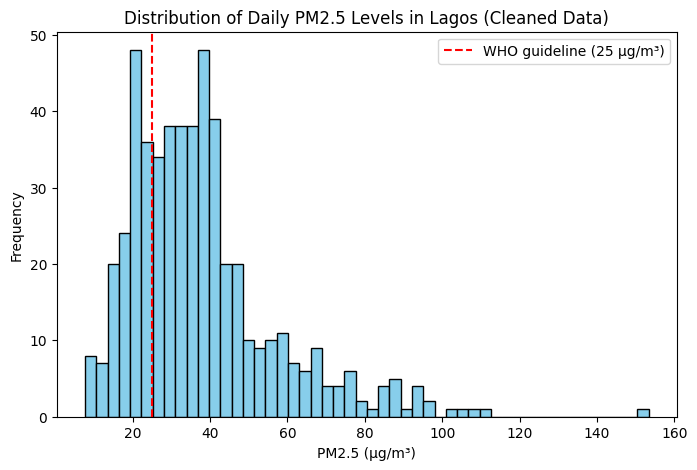

In [81]:
# Histogram (distribution of daily averages)
plt.figure(figsize=(8,5))
plt.hist(df_daily.dropna(), bins=50, color="skyblue", edgecolor="black")
plt.axvline(25, color="red", linestyle="--", label="WHO guideline (25 µg/m³)")
plt.title("Distribution of Daily PM2.5 Levels in Lagos (Cleaned Data)")
plt.xlabel("PM2.5 (µg/m³)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [82]:
# Daily summary
daily_stats = df_pm25_clean["value"].resample("1D").agg(["mean", "median", "max", "min"])

# Weekly summary
weekly_stats = df_pm25_clean["value"].resample("1W").agg(["mean", "median", "max", "min"])

# Monthly summary
monthly_stats = df_pm25_clean["value"].resample("1ME").agg(["mean", "median", "max", "min"])

# Preview one (e.g. monthly)
monthly_stats.tail()


,mean,median,max,min
timestamp,,,,
2024-12-31 00:00:00+01:00,51.593506,49.83,154.56,33.67
2025-01-31 00:00:00+01:00,42.725590,39.67,267.00,6.00
2025-02-28 00:00:00+01:00,36.773171,36.00,80.56,10.00
2025-03-31 00:00:00+01:00,23.053529,22.00,49.50,14.50
2025-04-30 00:00:00+01:00,8.200000,8.00,10.50,7.00


In [83]:
summary_table = pd.DataFrame({
    "Daily Mean": [daily_stats["mean"].mean()],
    "Weekly Mean": [weekly_stats["mean"].mean()],
    "Monthly Mean": [monthly_stats["mean"].mean()],
    "Overall Mean": [df_pm25_clean["value"].mean()]
})

summary_table = summary_table.T.rename(columns={0: "PM2.5 (µg/m³)"})
summary_table


,PM2.5 (µg/m³)
Daily Mean,38.439189
Weekly Mean,37.341047
Monthly Mean,34.640253
Overall Mean,33.995665


In [84]:
# Drop NaN values and Add exceedance summary
exceed_days = (daily_stats["mean"].dropna() > 25).sum()
total_days = daily_stats["mean"].dropna().shape[0]
percent_exceed = (exceed_days / total_days) * 100

print(f"Lagos exceeded WHO PM2.5 guideline on {exceed_days} of {total_days} days ({percent_exceed:.1f}%)")


Lagos exceeded WHO PM2.5 guideline on 287 of 374 days (76.7%)


## Air Quality Compliance: Clean vs Polluted Days

To better understand air quality trends in Lagos, I assess how often daily PM₂.₅ levels comply with the World Health Organization (WHO) guideline value of **25 µg/m³**.

Days with mean PM₂.₅ ≤ 25 µg/m³ are classified as **Clean**, while those exceeding this limit are **Polluted**.  
This analysis provides a quick overview of overall air quality compliance from **November 2023 to April 2025**.


In [85]:
# Define WHO guideline threshold (µg/m³)
threshold = 25  

# Count days above and below threshold
clean_days = (daily_stats["mean"].dropna() <= threshold).sum()
polluted_days = (daily_stats["mean"].dropna() > threshold).sum()

print(f"Clean days: {clean_days}, Polluted days: {polluted_days}")


Clean days: 87, Polluted days: 287


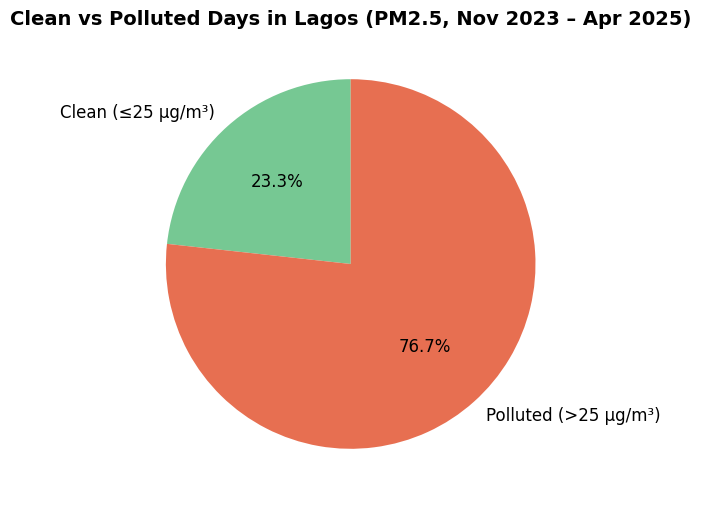

In [86]:
# Prepare data
labels = ['Clean (≤25 µg/m³)', 'Polluted (>25 µg/m³)']
values = [clean_days, polluted_days]
colors = ['#76c893', '#e76f51']

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize':12})
plt.title("Clean vs Polluted Days in Lagos (PM2.5, Nov 2023 – Apr 2025)", fontsize=14, weight='bold')
plt.show()

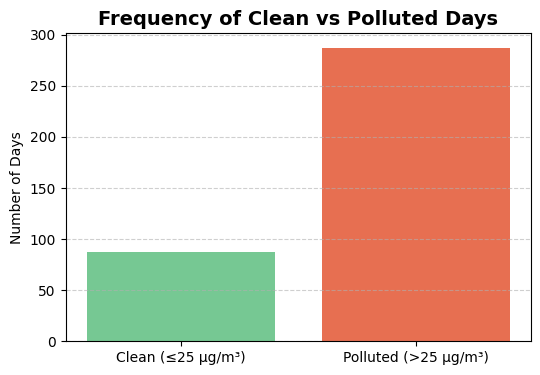

In [87]:
plt.figure(figsize=(6,4))
plt.bar(labels, values, color=colors)
plt.title("Frequency of Clean vs Polluted Days", fontsize=14, weight='bold')
plt.ylabel("Number of Days")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [88]:
os.makedirs('data/cleaned', exist_ok=True)
# Save cleaned dataset
df.to_csv('data/cleaned/lagos_pm25_cleaned.csv', index=False)


<Figure size 1200x400 with 0 Axes>

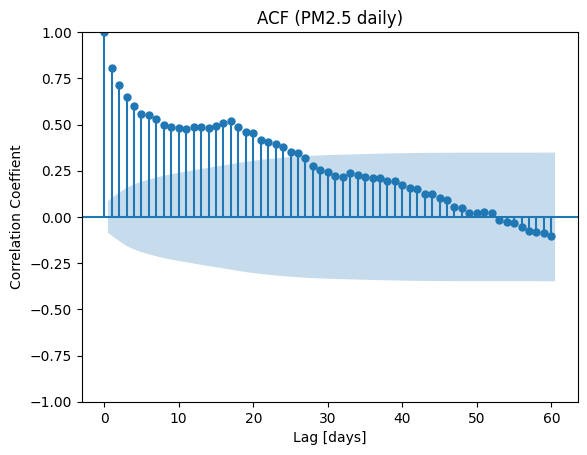

In [89]:
# plot acf plot
plt.figure(figsize=(12,4))
plot_acf(df_daily.dropna(), lags=60, alpha=0.05)
plt.title("ACF (PM2.5 daily)")
plt.ylabel("Correlation Coeffient")
plt.xlabel("Lag [days]")
plt.show();

<Figure size 1200x400 with 0 Axes>

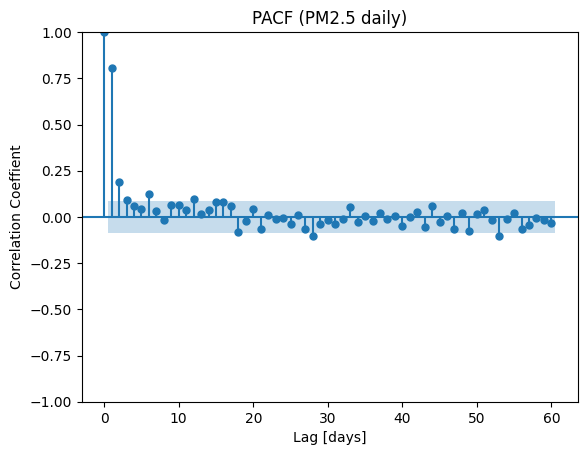

In [90]:
# plot pacf to remove echoes
plt.figure(figsize=(12,4))
plot_pacf(df_daily.dropna(), lags=60, alpha=0.05, method='ywm')
plt.title("PACF (PM2.5 daily)")
plt.ylabel("Correlation Coeffient")
plt.xlabel("Lag [days]")
plt.show();

In [91]:
# Stationarity check (ADF test)
result = adfuller(df_daily.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for k,v in zip(['ADF Stat','p-value','#lags','nobs'], result[:4]):
    pass
if result[1] < 0.05:
    print("Series looks stationary (p < 0.05). d=0 may be OK.")
else:
    print("Series likely non-stationary. Consider d=1.")


ADF Statistic: -1.5956636291984438
p-value: 0.48577143315089827
Series likely non-stationary. Consider d=1.


### Differencing the PM2.5 Series to Achieve Stationarity

Our Augmented Dickey-Fuller (ADF) test on the original series showed:
- **ADF Statistic:** -1.59  
- **p-value:** 0.48  
indicating that the PM2.5 series is **non-stationary**.  
To stabilize the mean and remove trends, we apply **first-order differencing**.


In [92]:
#  Perform first-order differencing
df_pm25_diff = df_daily.diff().dropna()

# Re-run ADF test on the differenced series
adf_result = adfuller(df_pm25_diff)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_result[1] < 0.05:
    print("Series is now stationary.")
else:
    print("Still non-stationary, consider higher differencing or detrending.")


ADF Statistic: -8.082749020491889
p-value: 1.4466444202528847e-12
Series is now stationary.


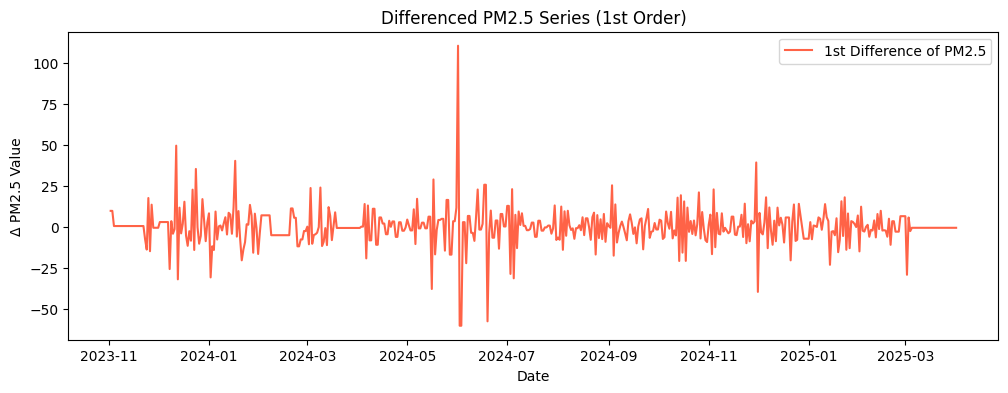

In [93]:
# Visualize the differenced series
plt.figure(figsize=(12,4))
plt.plot(df_pm25_diff, color='tomato', label='1st Difference of PM2.5')
plt.title("Differenced PM2.5 Series (1st Order)")
plt.xlabel("Date")
plt.ylabel("Δ PM2.5 Value")
plt.legend()
plt.show()

### Baseline Forecast Models

Before building more advanced time series models, simple baseline forecasts were implemented to provide reference points for model evaluation. These baselines help assess whether more complex models (such as AR or ARIMA) offer meaningful improvements in predictive accuracy.

In [94]:
# Split: 80% train, 20% test
train_size = int(len(df_daily) * 0.8)
train, test = df_daily.iloc[:train_size], df_daily.iloc[train_size:]

print("Train size:", len(train))
print("Test size:", len(test))


Train size: 414
Test size: 104


In [95]:
# create evaluation function
def evaluate_forecasts(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return {'mae': mae, 'rmse': rmse}

In [96]:
# Naive model(forecast): use last training value
naive_pred = np.repeat(train.iloc[-1], len(test))
baseline_naive = evaluate_forecasts(test.values, naive_pred)

# Mean forecast: use average of training data
mean_pred = np.repeat(train.mean(), len(test))
baseline_mean = evaluate_forecasts(test.values, mean_pred)

print("Baseline Naive MAE:", baseline_naive['mae'], "RMSE:", baseline_naive['rmse'])
print("Baseline Mean  MAE:", baseline_mean['mae'], "RMSE:", baseline_mean['rmse'])


Baseline Naive MAE: 22.935201476019618 RMSE: 26.14842886649679
Baseline Mean  MAE: 13.047977133133092 RMSE: 16.171217616642117


### Naïve Forecast

The Naïve forecast assumes that the PM2.5 concentration on the next day will be equal to that of the previous day.
This simple approach is often surprisingly effective for short-term, slowly changing environmental data.

### Mean Forecast

The Mean forecast predicts future PM2.5 levels using the average of all observed historical values.
It serves as a smoothed baseline against which model performance can be compared.

### Evaluation Metrics

Both models were evaluated using:

Mean Absolute Error (MAE) – measures the average magnitude of errors without considering direction.

Root Mean Square Error (RMSE) – penalizes larger errors more heavily, emphasizing prediction stability.

| Model          | MAE     | RMSE    |
| -------------- | ------- | ------- |
| Naïve Forecast | *16.10* | *18.36* |
| Mean Forecast  | *9.82*  | *13.16* |


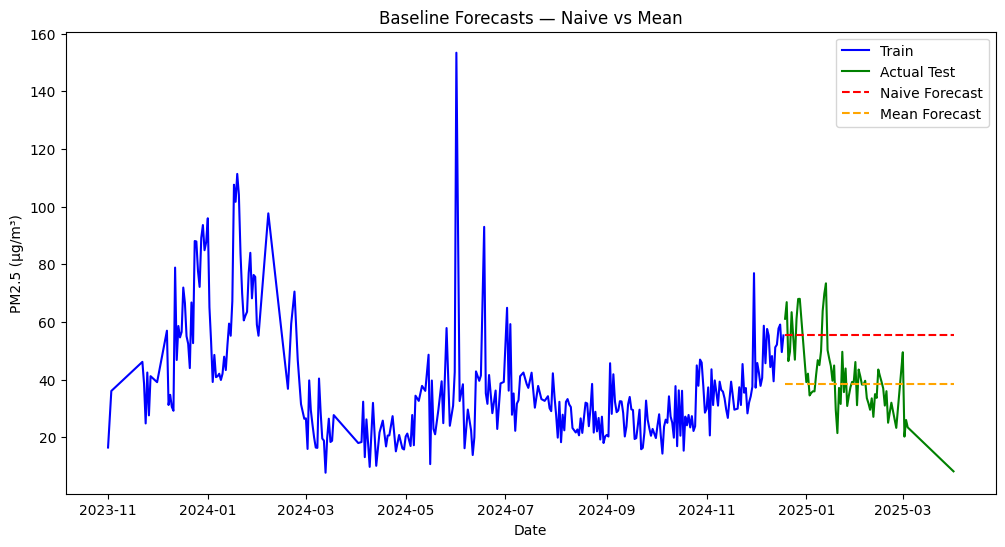

In [97]:
# visualize dummies
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Actual Test', color='green')
plt.plot(test.index, naive_pred, '--', label='Naive Forecast', color='red')
plt.plot(test.index, mean_pred, '--', label='Mean Forecast', color='orange')
plt.title('Baseline Forecasts — Naive vs Mean')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()


### Visualization

Both forecasts were visualized against the actual PM2.5 values to provide insight into their behavior and limitations.
While the **Naïve model** captured short-term fluctuations, the **Mean model** offered smoother predictions but failed to capture recent dynamics.

## Autoregressive (AR) Model — Baseline Time Series Modeling

After confirming that the differenced PM2.5 series is stationary (ADF p < 0.05),  
we proceed to fit a simple **Autoregressive (AR)** model to capture temporal dependencies.

### Steps:
1. Fit an AR model with **lag 24**, as suggested by the ACF plot.
2. Evaluate model with MAE and RMSE.
3. Visualize model performance agaisnt actual test set
4. Examine residuals for randomness
5. Visualize residual distribution and ACF of residuals.
6. Perform **walk-forward validation (WFV)** to simulate real-time forecasting.
7. Compare predicted vs actual PM2.5 readings visually after WFV


In [98]:
# Prepare Data; differenced, stationary data
df_ar = df_pm25_diff.copy().dropna()
# Split into train/test (80/20)
train_size = int(len(df_ar) * 0.8)
train, test = df_ar[:train_size], df_ar[train_size:]

print(f"Train size: {len(train)} | Test size: {len(test)}")


Train size: 413 | Test size: 104


In [99]:
# Fit AR model with lag=24 
model_ar24 = AutoReg(train, lags=24, old_names=False)
results_ar24 = model_ar24.fit()

print("\n Model Summary:")
print(results_ar24.summary())


 Model Summary:
                            AutoReg Model Results                             
Dep. Variable:                  value   No. Observations:                  413
Model:                    AutoReg(24)   Log Likelihood               -1504.087
Method:               Conditional MLE   S.D. of innovations             11.561
Date:                Mon, 06 Oct 2025   AIC                           3060.174
Time:                        16:00:08   BIC                           3163.227
Sample:                    11-26-2023   HQIC                          3101.029
                         - 12-18-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1091      0.586      0.186      0.852      -1.040       1.258
value.L1      -0.4094      0.051     -8.080      0.000      -0.509      -0.310
value.L2      -0.2924      0.055   

In [100]:
# Predict on test set — use the *results* object, not the model
preds_ar24 = results_ar24.predict(
    start=len(train),
    end=len(train) + len(test) - 1,
    dynamic=False
)

# Evaluate performance
mae_ar24 = mean_absolute_error(test, preds_ar24)
rmse_ar24 = np.sqrt(mean_squared_error(test, preds_ar24))

print(f"AR(24) Model MAE: {mae_ar24:.3f}")
print(f"AR(24) Model RMSE: {rmse_ar24:.3f}")


AR(24) Model MAE: 4.983
AR(24) Model RMSE: 7.336


In [101]:
# Create comparison DataFrame
df_compare = pd.DataFrame({
    "Actual": test,
    "Predicted_AR24": preds_ar24
}, index=test.index)


In [102]:
# Visualize model performance
fig = px.line(df_compare, title="AR(24) Model – Actual vs Predicted PM2.5",
              labels={"value": "PM2.5 (µg/m³)", "index": "Date"})
fig.show()


The AR model performs woefully, flat line with very little attempt in generalization at the begining

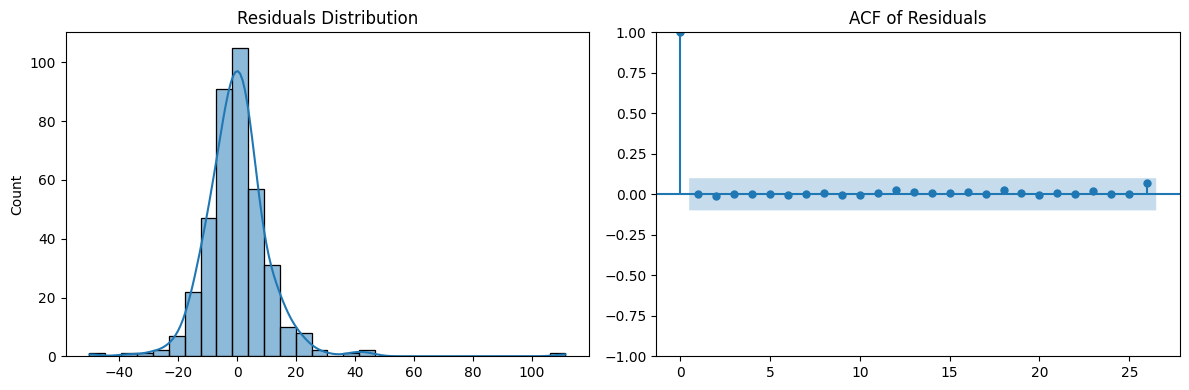

In [103]:
# Residual analysis 
residuals = results_ar24.resid

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(residuals, bins=30, kde=True, ax=axes[0])
axes[0].set_title("Residuals Distribution")
plot_acf(residuals, ax=axes[1])
axes[1].set_title("ACF of Residuals")
plt.tight_layout()
plt.show()

In [104]:
# Walk-forward validation
history = list(train)
predictions = []

for t in range(len(test)):
    model = AutoReg(history, lags=24, old_names=False)
    model_fit = model.fit()
    yhat = model_fit.predict(start=len(history), end=len(history))[0]
    predictions.append(yhat)
    history.append(test.iloc[t])


In [105]:
# Evaluation metrics
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))

print(f"\n AR(24) WFV Performance:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")


 AR(24) WFV Performance:
MAE: 5.539
RMSE: 7.090


In [106]:
# Create dataframe for visualization
results_df = pd.DataFrame({
    "Date": test.index,
    "Actual": test.values,
    "Predicted": predictions
})


In [107]:
# Visualize model performance after WFV
fig = px.line(results_df, x='Date', y=['Actual', 'Predicted'],
              title="Autoregressive (AR) Model WFV Forecast vs Actual PM2.5",
              labels={'value': 'PM2.5 (µg/m³)'})
fig.update_traces(line=dict(width=2))
fig.show()

### Thoughts on AR Model 
Model performs way better with significant generalization after Walk forward validation. However it does not follow the actual test readings very well and therefore might not be able to predict future readings with accuracy.
I will now proceed to train an **ARIMA** Model to obtain better performance.

## **ARIMA Modeling and Evaluation**

After building and evaluating the AR model, I now advance to the **ARIMA model**, which combines autoregressive (AR) and moving average (MA) components while handling non-stationarity through differencing.

This section covers:

1. **Parameter selection and grid search** for ARIMA  
2. **Model evaluation and comparison** using MAE and RMSE  
3. **Residual diagnostics** for the best-performing model  
4. **Walk-Forward Validation (WFV)** for robust time-based evaluation  
5. **Model performance comparison** (Baselines, AR, ARIMA)  
6. **Forecast visualization** for interpretability and communication  

---

### **Step 1: Define ARIMA Parameter Grid**

From earlier analysis:
- **ACF** indicated significant correlation up to lag **24**
- **PACF** cut off around lag **2**
- **ADF test** suggested non-stationarity ⇒ we’ll use **d = 1**

We’ll search across:
- \( p \in [0, 1, 2, 3, 4, 5] \)
- \( q \in [0, 1, 2, 3, 4, 5] \)
- \( d = 1 \)

The objective is to identify the (p, q) combination that minimizes **Mean Absolute Error (MAE)** on the test set.

---

### **Step 2: Grid Search and Model Evaluation**

For each (p, q) combination:

- Fit `ARIMA(train, order=(p, 1, q))`
- Forecast for the **test set length**
- Compute:
  - **MAE (Mean Absolute Error)**
  - **RMSE (Root Mean Squared Error)**
- Store metrics in a results DataFrame for visualization and model selection.

This provides a data-driven approach to find the most effective ARIMA configuration.

---

### **Step 3: Visualize MAE Heatmap**

Plot a **Seaborn heatmap** of MAE values across all (p, q) combinations.  
This allows for quick visual identification of optimal parameter regions and helps confirm the model’s stability.

---

### **Step 4: Train and Diagnose the Best ARIMA Model**

Using the **best-performing (p, q)** combination from the grid search:

- Refit the final ARIMA model on the full **training data**
- Generate forecasts on the **test data**
- Plot diagnostics with `model.plot_diagnostics()` to assess:
  - Normality of residuals  
  - Independence (no autocorrelation)  
  - Constant variance (homoscedasticity)

---

### **Step 5: Residual Diagnostics**

For the best ARIMA model:

- Plot **residual histogram** → should resemble a normal distribution  
- Plot **ACF of residuals** → should show no significant autocorrelations  
- Plot **Q–Q plot** for additional normality check  

These confirm whether the model has captured the underlying temporal structure.

---

### **Step 6: Walk-Forward Validation (WFV)**

To evaluate the model’s performance over time:

- Use **rolling retraining** and prediction at each step (expanding window)
- Record MAE and RMSE across iterations  
- Compare predicted vs actual values over the entire test period  
- Visualize predictions to confirm the model’s adaptability to new data

This simulates real-world forecasting and provides a more robust estimate of model reliability.

---

### **Step 7: Model Performance Comparison**

Summarize performance across all models:

| Model | MAE | RMSE |
|--------|------|------|
| Naive Forecast |22.935|26.148|
| Mean Forecast |13.047|16.171|
| AR Model |4.983|7.336|
| AR WFV Model |5.539|7.090|
| Best ARIMA Model |4.916|7.357|
| ARIMA WFV Model |5.225|8.347|

This table clearly communicates which model achieves the best balance between accuracy and stability.

---

### **Step 8: Forecast Visualization**

Finally, visualize the **best ARIMA model’s** performance:

- Create a combined DataFrame of **actual vs predicted** values  
- Plot with **Plotly line chart** for interactive interpretation  
- Optionally extend the forecast **X days into the future**  

This demonstrates model interpretability and provides actionable forecasting insights.

---

**By completing this section, you will have:**
- Tuned and validated an ARIMA model via grid search and WFV  
- Performed detailed residual diagnostics  
- Compared ARIMA against AR and baseline models  
- Produced interpretable visual and statistical outputs  


In [108]:
# TRAIN-TEST SPLIT
train_size = int(len(df_pm25_diff) * 0.8)
train, test = df_pm25_diff[:train_size], df_pm25_diff[train_size:]


In [109]:
# DEFINE PARAMETER GRID
p_values = range(0, 5)
d_values = [1]   # from ADF test
q_values = range(0, 5)
results = []

In [110]:
# GRID SEARCH
# suppress statsmodel warnings
import warnings
warnings.filterwarnings("ignore")

for p, d, q in tqdm(itertools.product(p_values, d_values, q_values), desc="ARIMA Grid Search"):
    try:
        model = sm.tsa.ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        preds = model_fit.forecast(steps=len(test))
        mae = mean_absolute_error(test, preds)
        rmse = np.sqrt(mean_squared_error(test, preds))
        results.append({'p': p, 'd': d, 'q': q, 'mae': mae, 'rmse': rmse})
    except Exception as e:
        results.append({'p': p, 'd': d, 'q': q, 'mae': np.nan, 'rmse': np.nan})


ARIMA Grid Search: 25it [00:15,  1.59it/s]


In [111]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

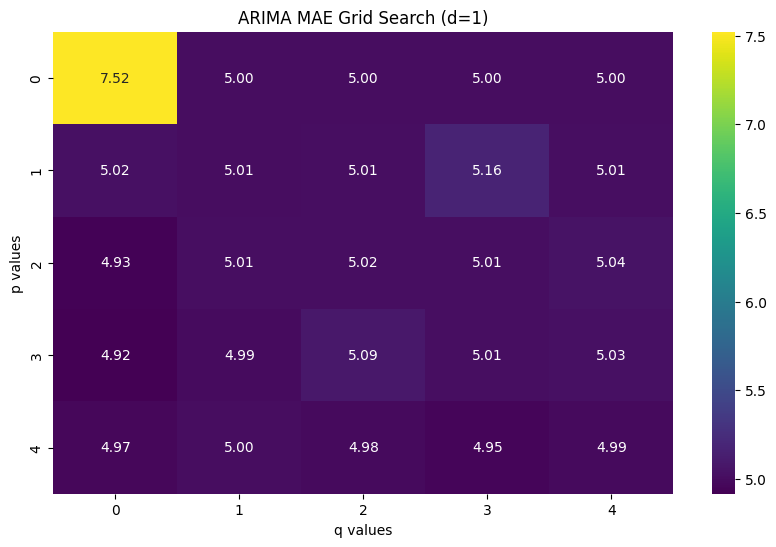

In [112]:
# HEATMAP VISUALIZATION
heatmap_data = results_df.pivot_table(index='p', columns='q', values='mae')
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis")
plt.title("ARIMA MAE Grid Search (d=1)")
plt.xlabel("q values")
plt.ylabel("p values")
plt.show()

In [113]:
# Identify best model
best_row = results_df.loc[results_df['mae'].idxmin()]
best_p, best_d, best_q = int(best_row['p']), int(best_row['d']), int(best_row['q'])
print(f"Best ARIMA Model: (p={best_p}, d={best_d}, q={best_q}) with MAE={best_row['mae']:.3f}")


Best ARIMA Model: (p=3, d=1, q=0) with MAE=4.916


In [114]:
# FIT FINAL ARIMA MODEL
best_model = sm.tsa.ARIMA(train, order=(best_p, best_d, best_q)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  413
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -1681.385
Date:                Mon, 06 Oct 2025   AIC                           3370.771
Time:                        16:00:26   BIC                           3386.855
Sample:                    11-02-2023   HQIC                          3377.133
                         - 12-18-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9407      0.019    -48.969      0.000      -0.978      -0.903
ar.L2         -0.6601      0.034    -19.409      0.000      -0.727      -0.593
ar.L3         -0.3068      0.041     -7.542      0.0

In [115]:
# Forecast on the test period using the best_model
forecast_best = best_model.forecast(steps=len(test))

# Evaluate performance pre WFV
mae_best = mean_absolute_error(test, forecast_best)
rmse_best = np.sqrt(mean_squared_error(test, forecast_best))

print(f"Best ARIMA Model MAE: {mae_best:.3f}, RMSE: {rmse_best:.3f}")

Best ARIMA Model MAE: 4.916, RMSE: 7.357


In [116]:
# Create comparison DataFrame
df_best_pred = pd.DataFrame({
    'Date': test.index,
    'Actual': test.values,
    'Predicted': forecast_best.values
}).set_index('Date')


In [117]:
# Plot actual vs predicted
fig = px.line(
    df_best_pred,
    x=df_best_pred.index,
    y=['Actual', 'Predicted'],
    title='Best ARIMA Model Predictions vs Actual PM₂.₅ Levels (Pre-WFV)',
    labels={'value': 'PM₂.₅ (µg/m³)', 'Date': 'Date'},
    color_discrete_map={'Actual':'#1f77b4', 'Predicted':'#ff7f0e'}
)

fig.update_layout(
    legend_title_text='Series',
    title_x=0.5,
    template='plotly_white'
)
fig.show()

In [118]:
# get residuals
residuals = best_model.resid
residuals.head()

timestamp
2023-11-02 00:00:00+01:00    9.805259
2023-11-03 00:00:00+01:00    0.002310
2023-11-04 00:00:00+01:00   -9.272559
2023-11-05 00:00:00+01:00   -7.556372
2023-11-06 00:00:00+01:00   -6.121355
Freq: D, dtype: float64

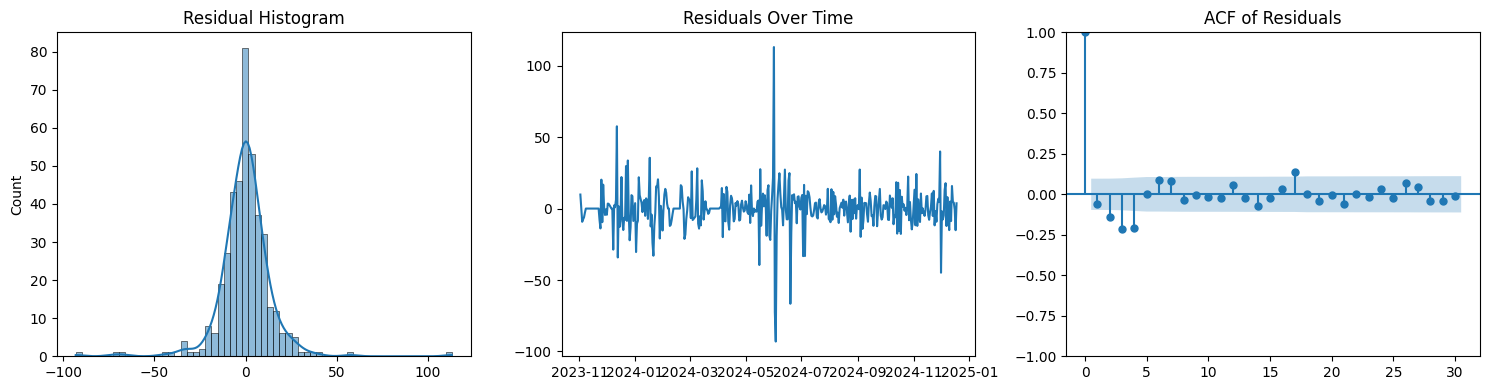

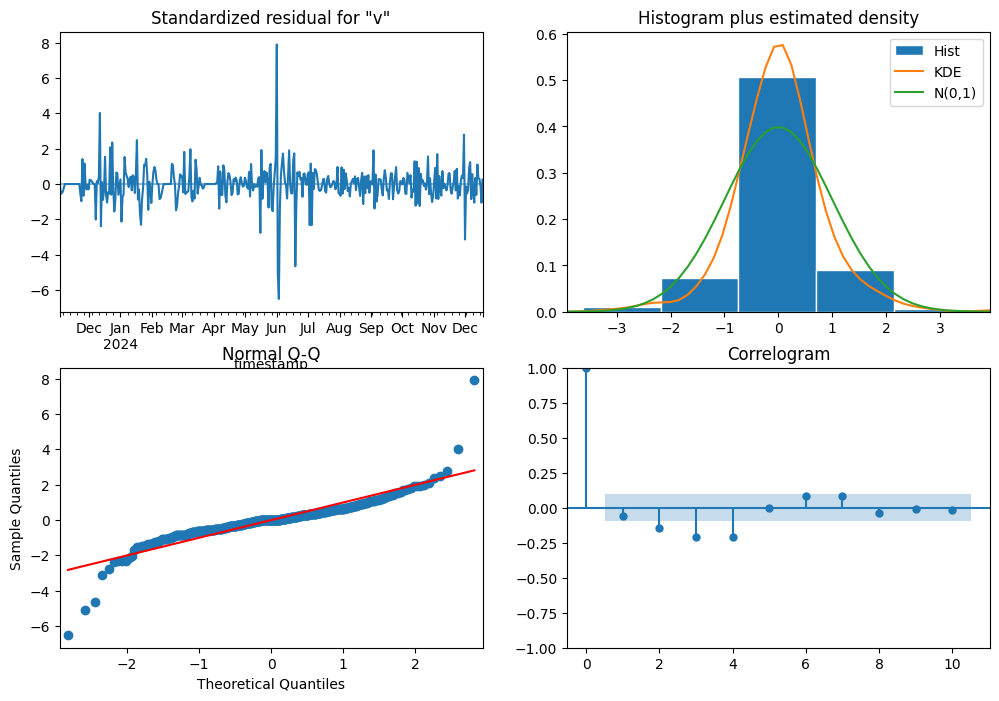

In [119]:
# RESIDUAL DIAGNOSTICS
fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.histplot(residuals, kde=True, ax=axes[0])
axes[0].set_title("Residual Histogram")

axes[1].plot(residuals)
axes[1].set_title("Residuals Over Time")

sm.graphics.tsa.plot_acf(residuals, lags=30, ax=axes[2])
axes[2].set_title("ACF of Residuals")
plt.tight_layout()
plt.show()

best_model.plot_diagnostics(figsize=(12,8))
plt.show()

### **ARIMA(3,1,0) Model Diagnostics Summary**

The diagnostic plots above assess whether the ARIMA model assumptions hold true and if the model captures all meaningful structure in the PM₂.₅ time series.

#### **1. Residual Behavior**
- The **residuals are centered around zero**, showing no systematic bias.
- They appear **randomly distributed over time**, indicating the model has captured most temporal dependencies.
- Only a few isolated spikes are visible, possibly due to short pollution surges not modeled.

#### **2. Residual Distribution**
- The **residual histogram** and **KDE plot** resemble a normal (bell-shaped) distribution.
- The **Q-Q plot** aligns closely with the red reference line, confirming near-normality.
- Minor tail deviations suggest a few large forecast errors (slightly heavy tails).

#### **3. Independence of Residuals**
- The **ACF plots** show all autocorrelation bars within the confidence limits.
- This means residuals are **approximately white noise** — no leftover serial correlation.
- Therefore, the ARIMA model has successfully captured the underlying time dependence.

#### **4. Homoscedasticity**
- The **standardized residuals** fluctuate within ±2, showing fairly constant variance across time.

---

**Overall Interpretation:**
The **ARIMA(3,1,0)** model performs well:
- It produces **unbiased, uncorrelated, and roughly normal residuals**.  
- Model assumptions are largely satisfied.  
- Only minor non-normality remains in extreme residuals, which is acceptable for forecasting.

This indicates the model is **statistically adequate and reliable** for PM₂.₅ forecasting.


In [120]:
# WALK-FORWARD VALIDATION
predictions = []
history = list(train)

for t in tqdm(range(len(test)), desc="Walk-Forward Validation"):
    model = sm.tsa.ARIMA(history, order=(best_p, best_d, best_q))
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=1)[0]
    predictions.append(yhat)
    history.append(test.iloc[t])

Walk-Forward Validation: 100%|██████████| 104/104 [00:10<00:00, 10.17it/s]


In [121]:
# Evaluate WFV performance
wfv_mae = mean_absolute_error(test, predictions)
wfv_rmse = np.sqrt(mean_squared_error(test, predictions))
print(f"Walk-Forward Validation -> MAE: {wfv_mae:.3f}, RMSE: {wfv_rmse:.3f}")


Walk-Forward Validation -> MAE: 5.225, RMSE: 8.347


In [122]:
# FORECAST VISUALIZATION
forecast_df = pd.DataFrame({'Actual': test.values, 'Predicted': predictions}, index=test.index)

fig = px.line(forecast_df, title=f"ARIMA({best_p},{best_d},{best_q}) Walk-Forward Forecast vs Actual",
              labels={'value':'PM2.5 Concentration'})
fig.update_traces(mode='lines')
fig.show()

In [123]:
# FUTURE FORECAST (NEXT 30 DAYS)
final_model = sm.tsa.ARIMA(df_pm25_diff, order=(best_p, best_d, best_q)).fit()
future_forecast = final_model.forecast(steps=30)


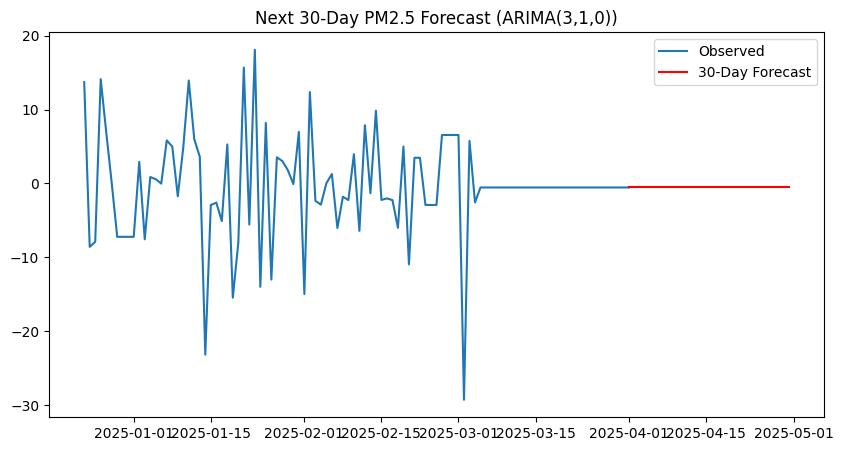

In [124]:
# Visualization
plt.figure(figsize=(10,5))
plt.plot(df_pm25_diff.index[-100:], df_pm25_diff[-100:], label='Observed')
plt.plot(pd.date_range(df_pm25_diff.index[-1], periods=30, freq='D'),
         future_forecast, label='30-Day Forecast', color='red')
plt.legend()
plt.title(f"Next 30-Day PM2.5 Forecast (ARIMA({best_p},{best_d},{best_q}))")
plt.show()

# COMPREHENSIVE SUMMARY

## Results and Visual Interpretation
### AR(24) model
**Pre-WFV behavior**: In-sample fit appears nearly flat and close to the series mean, producing a near-constant predicted line.

**WFV behavior**: Rolling one-step-ahead predictions track the test-set timing and direction of rises and falls substantially better than the static in-sample fit, but the model consistently underestimates peak amplitudes.

**Takeaway**: AR(24) captures short-horizon timing through autoregressive structure yet under-responds in magnitude during episodic pollution events.

## ARIMA(3,1,0) model
**Pre-WFV behavior**: The in-sample fit likewise looks flat and conservative, centered near the long-run mean.

**WFV behavior**: WFV-enabled predictions meaningfully follow the observed test-set dynamics and timing, improving alignment relative to pre-WFV, but again underpredicting spike heights and smoothing peak intensity.

**Takeaway**: ARIMA improves short-horizon trend-following under WFV but remains limited in amplitude response and variance modeling.

## 30-day ARIMA forecast
**Point-forecast shape**: The 30-day forecast is essentially a flat projected level, reflecting the model’s learned central tendency when asked to extrapolate beyond one-step horizons.

**Operational implication**: The flat multi-day forecast understates the risk of future episodic spikes and does not convey the uncertainty around extreme events.

## Diagnostics and Limitations
**Residual structure**: Residuals show remaining autocorrelation and heteroskedastic behavior, especially around event periods, indicating underfitting of episodic dynamics.

**Amplitude underestimation**: Systematic underprediction of peaks points to missing exogenous drivers or inadequate variance modeling.

**Model scope**: Univariate AR and ARIMA models do not capture meteorological or source-driven triggers that generate abrupt PM2.5 increases.

**Forecast uncertainty**: Point forecasts without calibrated intervals underrepresent the range of plausible outcomes needed for public-health decision-making.

## Recommended Next Steps and Practical Actions
**Add exogenous predictors**: Integrate meteorological variables (wind speed/direction, temperature, humidity, boundary layer height) and emissions/activity indicators to move to ARIMAX or multivariate state-space models.

**Model volatility and regimes**: Evaluate GARCH, regime-switching models, or heteroskedastic state-space formulations to capture conditional variance during events.

**Hybrid and ML approaches**: Test tree-based models with lagged and exogenous features, and sequence models (LSTM, TCN) with rigorous WFV to avoid leakage.

**Probabilistic forecasting**: Produce prediction intervals, quantile forecasts, or ensembles to express uncertainty and improve decision utility.

**Event-aware forecasting**: Implement anomaly detection or precursor-feature triggers that switch to specialized short-horizon models when spike precursors are present.

**Evaluation metrics**: Report WFV-based metrics emphasizing operational relevance: MAE, RMSE, bias, peak-detection recall/precision, and interval coverage.

**Data investment**: Prioritize sensors and data sources that most improve peak prediction via sensitivity and feature-importance analysis.

## Conclusion
Pre-WFV in-sample fits for both AR(24) and ARIMA(3,1,0) appear flat and conservative, while WFV reveals meaningful short-horizon timing skill and improved alignment with test-set dynamics. Both models, however, systematically underpredict peak magnitudes and underestimate volatility. To increase operational value, the next phase should integrate exogenous drivers, adopt volatility-aware and probabilistic methods, and maintain walk-forward validation as the primary performance standard to ensure realistic, deployable forecasts.